In [7]:
import os
import sys
import edt
import time
import math
import random
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from alive_progress import alive_bar


def checkPlotPath(path = 'dataOut/'):
    # Check path and create if does not exist
    if not os.path.isdir(path):
        os.makedirs(path)
    return path

class solid(object):
    """
    Store solid information
    """
    def __init__(self,
                 xy = [0,0],
                 radius = 0,
                 periodic = False):
         self.xy = xy
         self.radius = radius
         self.periodic = periodic
         self.area = np.pi*self.radius*self.radius

    def check_Bounds(self,domainData,eps = 1.e-3):
        """
        Determine if circle is within a given domain by checking each of the four sides
        """
        up    = self.xy[1] + self.radius > domainData[1] - eps
        down  = self.xy[1] - self.radius < eps
        left  = self.xy[0] - self.radius < eps
        right = self.xy[0] + self.radius > domainData[0] - eps
        
        inBounds = True
        if up or down or left or right:
            inBounds = False

        return inBounds
         
    def overlap_check(self,otherCircle): 
        """
        Determine if circle overlaps with other circle with distance formula
        The square root operation is slow so will will square everythin
        Circles overlap if 
            (x_c - x_o)^2 + (y_c - y_o)^2 < (r_c + r_o)^2 
        """
        dx = self.xy[0] - otherCircle.xy[0]
        dy = self.xy[1] - otherCircle.xy[1]
        sumRadii = self.radius + otherCircle.radius
        distance = dx*dx + dy*dy
        overlap = False
        if distance < sumRadii*sumRadii: 
            overlap = True
        return overlap


class circlePacking(object):
    def __init__(self,
                 domain = [1,1],
                 porosity = 1,
                 distribution = 'uniform',
                 distParam = [0.1,1],
                 maxTime = 120.):
        self.domain = domain
        self.domainArea = domain[0]*domain[1]
        self.porosityIn = porosity
        self.solids = []
        self.solidArea = 0
        self.numSolids = 0
        self.porosity = 1
        self.distParam = distParam
        self.maxTime = maxTime
        self.distString = 'porosity_'+str(porosity)+'_'+distribution+'_'+str(self.distParam[0])+'_'+str(self.distParam[1])

        ### Set Appropriate Distribution
        if distribution == 'normal':
            self.distribution = np.random.normal
        elif distribution == 'lognormal':
            self.distribution = np.random.lognormal
        elif distribution == 'uniform':
             self.distribution = random.uniform
        else:
            print("Error! Unknown Distribution. Setting to Uniform ")
            self.distribution = random.uniform        

    def generate_packing(self):
        ###Parameters units are in nanometers

        #Generate circles
        print("\nCircle Packing in Progress...")
        startTime = time.time(); elapsedTime = 0
        with alive_bar(0,manual=True) as bar:
            while (self.porosity > self.porosityIn) and (elapsedTime < self.maxTime):
                elapsedTime = time.time() - startTime

                # Get Random Location in Domain 
                sX = random.uniform(0, self.domain[0])
                sY = random.uniform(0, self.domain[1])

                # Sample from Provided Distibution -  Ensure Positive
                negative = True
                while negative:
                    sR = self.distribution(self.distParam[0], self.distParam[1])
                    negative = sR <= 0
                cSolid = solid(xy = [sX,sY], radius = sR)

                if cSolid.check_Bounds(self.domain):
                    globalOverlapCheck = True
                    for s in self.solids:
                        if cSolid.overlap_check(s):
                            globalOverlapCheck = False
                            continue

                    if globalOverlapCheck:
                            self.solids.append(cSolid)
                            self.solidArea = self.solidArea + cSolid.area
                            self.porosity = 1. - self.solidArea/self.domainArea
                            self.numSolids += 1

                            poreFrac = self.porosityIn/self.porosity
                            barValue = 1 if poreFrac > 1 else poreFrac
                            bar(barValue)
            
        if (elapsedTime >= self.maxTime):
            bar.disable=True
            print('Maximum Time Reached. Exiting! \n')
            sys.exit()
        else:
            bar(1)
            print('Circle Packing Completed!')

        
    def plot_packing(self):
        """
        Plot all of the solids in the domain
        """
        # Check path and create if does not exist
        path = checkPlotPath()

        # Generate plot
        fig, ax = plt.subplots() 
        ax.set_xlim((0, self.domain[0]))
        ax.set_ylim((0, self.domain[1]))
        ax.set_aspect('equal', 'box')
        ax.set_facecolor("darkblue")
        for s in self.solids:
            circle = plt.Circle(s.xy, s.radius, color='w')
            ax.add_patch(circle)
        fig.savefig(path+'packing'+'_'+self.distString+'.pdf')

class digitizedDomain(object):
    def __init__(self,
                 packing,
                 nodes = [100,100]):
        self.packing = packing
        self.nodes = nodes
        self.sumNodes = nodes[0]*nodes[1]
        self.domain = self.packing.domain
        self.dx = self.domain[0]/self.nodes[0]
        self.dy = self.domain[1]/self.nodes[1]
        self.x = np.linspace(self.dx/2., self.domain[0]-self.dx/2., num=nodes[0])
        self.y = np.linspace(self.dy/2., self.domain[1]-self.dy/2., num=nodes[1])
        self.grid = np.ones(nodes,dtype=np.uint8)


    def generate_domain(self):
        """
        Loop through all nodes and see if licated in solid
        """
        print("\nDigitizing Domain...")
        with alive_bar(self.sumNodes,manual=True) as bar:
            count = 0
            for nx in range(self.nodes[0]):
                for ny in range(self.nodes[1]):
                    sCount = 0
                    while self.grid[nx,ny] != 0 and sCount < self.packing.numSolids:
                        curSolid = self.packing.solids[sCount]
                        node = solid(xy = [self.x[nx],self.y[ny]])
                        if curSolid.overlap_check(node):
                            self.grid[nx,ny] = 0
                        sCount += 1
                    count += 1
                    bar(count/self.sumNodes)
        print("Digitizing Complete!")

    def sample_domain(self):

        xy = [self.domain[0]/2.,self.domain[1]/2.]

        # Get Maximum Radius
        maxRadius = np.min([xy[0],xy[1],self.domain[0] - xy[0],self.domain[1] - xy[1]])
        maxArea = np.pi*maxRadius*maxRadius
        diag = np.sqrt(self.dx*self.dx + self.dy*self.dy)
        intervals = math.floor(maxRadius/diag)

        # Calculate EDT from xy
        dist = np.ones_like(self.grid,dtype=np.uint8)
        indX = np.abs(self.x-xy[0]).argmin()
        indY = np.abs(self.y-xy[1]).argmin()
        dist[indX,indY] = 0
        self.dist = edt.edt(dist, anisotropy=(self.dx, self.dy) ) 

        self.porosityREV = np.zeros(intervals+1)
        self.areaREV = np.zeros(intervals+1)

        print("\nSampling Domain...")
        with alive_bar(intervals,manual=True) as bar:
            self.porosityREV[0] = self.grid[indX,indY]
            for n in range(1,intervals+1):
                self.sample = np.where(self.dist < n*diag, self.grid, 2)
                sampleTrue =  np.where(self.dist < n*diag)

                for nx,ny in zip(sampleTrue[0],sampleTrue[1]):
                    self.porosityREV[n] += self.grid[nx,ny]
                    self.areaREV[n] += 1

                self.porosityREV[n] = self.porosityREV[n]/self.areaREV[n]
                self.areaREV[n] = self.areaREV[n]*(self.dx*self.dy)

                #self.plot_sample(n,porosityREV,areaREV,maxArea)
                bar(n/(intervals))

        print("Sampling Complete!")

    
    def plot_domain(self):
        """
        Plot digitized domain
        """
        # Check path and create if does not exist
        path = checkPlotPath()

        fig, ax = plt.subplots() 
        domain = [0,self.domain[0],0,self.domain[1]]
        plt.imshow(self.grid.T, extent = domain, origin = 'lower', cmap = 'Blues')
        fig.savefig(path+'digitizedDomain'+'_'+self.packing.distString+'.pdf')
        plt.close()

    def plot_distance(self):
        """
        Plot digitized domain
        """
        # Check path and create if does not exist
        path = checkPlotPath()

        fig, ax = plt.subplots() 
        domain = [0,self.domain[0],0,self.domain[1]]
        plt.imshow(self.dist.T, extent = domain, origin = 'lower', cmap = 'Blues_r')
        fig.savefig(path+'digitizedDistance'+'_'+self.packing.distString+'.pdf')
        plt.close()
            
    def plot_sample(self):
        """
        Plot digitized domain
        """
        # Check path and create if does not exist
        path = 'dataOut/samples/'
        path = checkPlotPath(path)

        fig, (ax1,ax2) = plt.subplots(1,2) 
        plt.tight_layout()
        domain = [0,self.domain[0],0,self.domain[1]]
        ax1.imshow(self.sample.T, extent = domain, origin = 'lower', cmap = 'Blues',vmin=0, vmax=2)

        ax2.plot(self.areaREV,self.porosityREV)
        ax2.set_ylim([0,1])
        ax2.set_box_aspect(1)
        ax2.set_xlabel("Area")
        ax2.set_ylabel("Porosity")

        fig.savefig(path+'digitizedSample'+'_'+self.packing.distString+'.pdf')
        plt.close()



Circle Packing in Progress...
|████████████████████████████████████████| 100% in 0.0s (35.87%/s) 
Circle Packing Completed!

Digitizing Domain...
|████████████████████████████████████████| 100% [40000/40000] in 7.7s (5226.33/s) 
Digitizing Complete!

Sampling Domain...
|████████████████████████████████████████| 100% [70/70] in 0.3s (227.60/s) 
Sampling Complete!


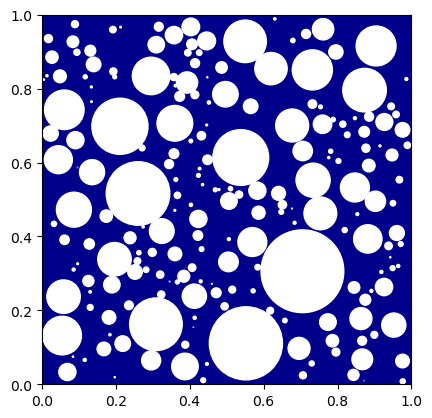

In [8]:

# Set Domain Size
domain = [1.,1.]

# Set Desired Porosity
# For a low porosity value, the code may time out and stop. 
porosity = 0.6

# Set Distribution and Paramters for Solid Radius
# Distribution can be 'normal','uniform', or 'lognormal'
# Parameter Values are
# 'uniform' -> [minValue,maxValue]
# 'normal' -> [mean,standard deviation]
# 'lognormal' -> [mean,standard deviation]

dist ='normal' 
param = [0.01,0.1] 

# Generate Solids
packing = circlePacking(domain,porosity,dist,param)
packing.generate_packing()
packing.plot_packing() 

# Digitize Porous Media
digi = digitizedDomain(packing, nodes = [200,200])
digi.generate_domain()

# Plot the Domain
digi.plot_domain()

# Sample Porous Media and calculate porosity
digi.sample_domain()

# Plot porosity vs sample area
digi.plot_sample()